<a href="https://colab.research.google.com/github/rajanieprabha/Polyp-Classification/blob/master/MLMI_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install torchvision==0.2.2

In [4]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
!pip install tqdm
!pip install tensorboardX
!pip install tensorboardcolab

import torch
print(torch.__version__)
print(torch.cuda.is_available())

import numpy as np
import torch
import io
import torch.utils.data as utils
import torchvision.models as models
import torch.nn as nn

from torch.autograd import Variable
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from tensorboardX import SummaryWriter


1.2.0
True


In [16]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("Using CUDA") 

Using CUDA


Loading Dataset

In [5]:
# X_fer_full = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/X_fer_full.npy')
# Y_fer = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/Y_fer.npy')
# D_all = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/D_fer.npy')
# print("X_fer_full shape",X_fer_full.shape)
# print("Y_fer shape",Y_fer.shape)

X_train = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/X_train.npy')
Y_train = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/Y_train.npy')
print("X_train shape",X_train.shape)
print("Y_train shape",Y_train.shape)

X_val = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/X_val.npy')
Y_val = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/Y_val.npy')
print("X_val shape",X_val.shape)
print("Y_val shape",Y_val.shape)

X_test = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/X_test.npy')
Y_test = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/Y_test.npy')
print("X_test shape",X_test.shape)
print("Y_test shape",Y_test.shape)



class0 = 0
class1 = 0
class2 = 0
for i in range(len(Y_test)):
  if Y_test[i] == 0:
    class0 += 1
  elif Y_test[i] ==1 :
    class1 += 1
    
  elif Y_test[i] ==2:
    class2 += 1
    
print(class0, class1, class2)


X_train shape (1357, 224, 224, 3)
Y_train shape (1357,)
X_val shape (25, 224, 224, 3)
Y_val shape (25,)
X_test shape (158, 224, 224, 3)
Y_test shape (158,)
68 75 15


Mean and Standard Deviation of Train dataset

In [0]:
print(np.mean(X_train, axis=(0,1,2))/255)
print(np.std(X_train, axis=(0,1,2))/255)


[0.24736816 0.24736816 0.17708135]
[0.43364584 0.22782978 0.18105543]


In [0]:
#!rm Y_train.npy
!ls -al

Importing files from Local system

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Visualing Dataset

(224, 224, 3)


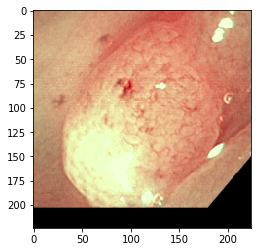

In [0]:

from matplotlib import pyplot as plt
X_train_check = X_train /  255.0
dataiter = X_train_check[400]
print(dataiter.shape)
plt.imshow(dataiter, interpolation='nearest')
plt.show()


Loading Model VGG with BN and Training

VGG


In [18]:
#vgg16 = models.vgg16_bn()
#vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth")

model_vgg = models.vgg11_bn(pretrained=True)
# UnFreeze training for all layers
for param in model_vgg.features.parameters():
    param.require_grad = True

# Newly created modules have require_grad=True by default
num_features = model_vgg.classifier[6].in_features

features = list(model_vgg.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 2)]) # Add our layer with 3 outputs
model_vgg.classifier = nn.Sequential(*features) # Replace the model classifier
model_vgg.classifier[2].p = 0.9
model_vgg.classifier[5].p = 0.9
print(model_vgg)
print("Final out channels =",(model_vgg.classifier[6].out_features) )

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=

Densenet

In [0]:
# #print(model_densenet)
# for param in model_densenet.features.parameters():
#     param.require_grad = True

# # Newly created modules have require_grad=True by default
# #num_features = model_densenet.classifier.num_features

# model_densenet.classifier = nn.Linear(1024, 2)# Replace the model classifier

# print(model_densenet)


Visualizing Data scatter using PCA

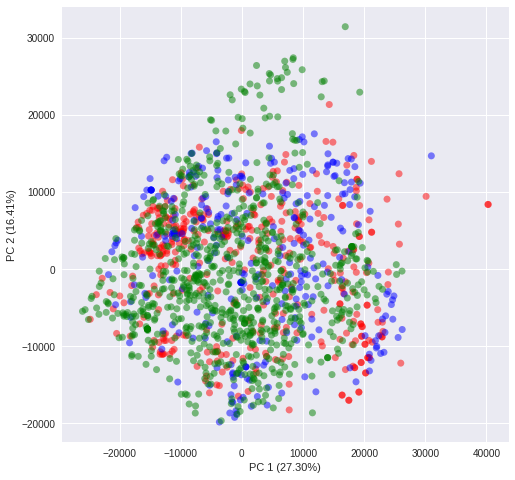

In [0]:
import seaborn as sns
import pandas as pd
import pylab
import matplotlib.cm as cm
import matplotlib
from sklearn.decomposition import PCA

# load decomposition to do PCA analysis with sklearn
%matplotlib inline
X_my = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/X_paper.npy')
Y_my = np.load('/content/gdrive/My Drive/ColabNotebooks/Data/Y_paper.npy')
#D_all = np.load('/content/gdrive/My Drive/ColabNotebooks/D_all.npy')
features = X_my.reshape(len(X_my),224*224*3)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)
label_color_dict = {label:idx for idx,label in enumerate(np.unique(Y_my))}

# Color vector creation
cvec = [label_color_dict[label] for label in Y_my]
colors = ['red','green','blue']
plt.figure(figsize=(8,8))
plt.scatter(features_pca[:,0], features_pca[:,1],
            c=cvec, edgecolor='', alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors))


# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# Done
plt.show()


Loading Transforms in Pytorch

In [0]:
#!pip install git+https://github.com/ncullen93/torchsample
#!pip install nipype --user 

#import torchsample as ts
train_tf= transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            #transforms.Resize(299),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ColorJitter(hue=.05, saturation=.05),
        
            #transforms.RandomCrop(224),
            transforms.RandomRotation(20), # data augmentation: rotation 
            transforms.ToTensor()
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            
        ])

Data Loader function

In [0]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class ImgLoader(Dataset):
    def __init__(self, x, y,iscuda=False,transforms = None):
        self.X = np.array(x)
        self.y = np.array(y)
        self.transform = transforms
#         self.cuda = iscuda
    
    def __getitem__(self, index):
   
        x_val = self.X[index]
        x_val = torch.from_numpy(x_val).permute(2, 1, 0)/255.0
        
        if self.transform is not None:
          #print("doing transformations")
          x_val = self.transform(x_val)
          
        y_val = torch.from_numpy(np.array([self.y[index]]))
#         if self.cuda:
#             x_val = x_val.cuda()
#             y_val = y_val.cuda()
        return x_val, y_val

    def __len__(self):
        return len(self.X)
    
   

Helper function for plotting curves

In [0]:

def show_curves(epochs, y_data1, y_data2, name ="Curve name"):
    plt.plot(np.arange(1, epochs + 1), y_data1)  # train loss (on epoch end)
    plt.plot(np.arange(1, epochs + 1), y_data2)         #  test loss (on epoch end)
    plt.title(name)
    plt.xlabel('epochs')
    plt.ylabel(name)
    plt.legend(['train', 'val'], loc="upper left")
    plt.show()
    #plt.savefig('-/results.png')


Helper functions 

In [0]:
def get_confusion_matrix(Y, Y_pred):
    N = len(Y)
    matrix = torch.zeros((2,2))
    for i in range(N):
        matrix[Y[i],Y_pred[i]] += 1
    return matrix
  
  
def accuracy(confusion_matrix):
    return (np.diag(confusion_matrix)).sum()/confusion_matrix.sum()*100
  
  
def precision(confusion_matrix):
    return np.diag(confusion_matrix) / torch.sum(confusion_matrix, 0)

def recall(confusion_matrix):
    return np.diag(confusion_matrix) / torch.sum(confusion_matrix, 1)

Train function

In [0]:
def train_iteration(loader, model, loss_fn, optim, use_gpu=True):
    losses = []
    
    model.train()
    for data in loader:
        X, Y = data
        Y = Y.long()
        if use_gpu:
            X, Y = Variable(X.cuda()), Variable(Y.squeeze(1).cuda())
        Y_pred = model(X)
        loss = loss_fn(Y_pred, Y)
        losses.append(loss.item())
       # Y_pred = torch.max(output,1)[1]
        #step_score = accuracy_score(Y.cpu().data.squeeze().numpy(), Y_pred.cpu().data.squeeze().numpy())
       # scores.append(step_score)
    
        # Compute gradients and make optimization step
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    #return np.mean(losses), np.mean(scores)*100
        del X, Y, Y_pred, loss
        torch.cuda.empty_cache()

Eval model function

In [0]:
def eval_model(loader, model, loss_fn, use_gpu=True):
    loss_value = 0.0
    conf_matrix = torch.zeros( (2,2) )
    model.eval()   
    with torch.no_grad():
        for data in loader:
            X, Y = data
            Y = Y.long()
            if use_gpu:
                X, Y = Variable(X.cuda()), Variable(Y.squeeze(1).cuda())
            Y_pred = model(X)
            loss = loss_fn(Y_pred, Y)
            loss_value += loss.item()
            conf_matrix += get_confusion_matrix(Y, torch.argmax(Y_pred, dim=1))
            del X, Y, Y_pred, loss
    loss_value /= len(loader)
    torch.cuda.empty_cache()
    return loss_value, conf_matrix
    

Helper function to get classification model (different options)

In [0]:
def get_net(net, dropout):
    if net=='alex':
        return Alex_Polyp(dropout)
    elif net[:3]=='den':
        return Dense_Polyp(dropout, net)
    elif net[:3]=='vgg':
        return VGG_Polyp(dropout, net)
    elif net=='inception':
        print("Generating Inception Net")
        model = torchvision.models.inception_v3(pretrained=True)
        model.aux_logits=False

        in_features = model.fc.in_features

        model.fc = nn.Linear(in_features, 2)
#         model = torchvision.models.inception_v3(pretrained=True)
#         model.fc = torch.nn.Linear(2048, 3)
#         model.aux_logits = False
        return model
    else:
        raise NotImplementedError
class Dense_Polyp(torch.nn.Module):
    def __init__(self, dropout = 0, net='densenet121'):
        super(Dense_Polyp, self).__init__()
        if net=='densenet121':
            model = torchvision.models.densenet121(pretrained=True, drop_rate = dropout)
        elif net=='densenet161':
            model = torchvision.models.densenet161(pretrained=False, drop_rate = dropout)
        elif net=='densenet169':
            model = torchvision.models.densenet169(pretrained=True, drop_rate = dropout)
        elif net=='densenet201':
            model = torchvision.models.densenet201(pretrained=True, drop_rate = dropout)
        else:
            raise NotImplementedError
        self.features = model.features
        
        
        self.classifier = torch.nn.Linear(model.classifier.in_features, 2)
       # nn.init.xavier_normal_(self.classifier.weight)
    
    def forward(self, x):
        features = self.features(x)
        out = torch.nn.functional.relu(features, inplace=True)
        out = torch.nn.functional.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
        out = self.classifier(out)
        return out

Lenet model

In [0]:

class LeNet(torch.nn.Module):          
     
    def __init__(self):     
        super(LeNet, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=48, kernel_size=11, stride=2, padding=0, bias=True)
        self.conv2 = torch.nn.Conv2d(in_channels=48, out_channels=72, kernel_size=5, stride=2, padding=0, bias=True)
        self.conv3 = torch.nn.Conv2d(in_channels=72, out_channels=1024, kernel_size=6, stride=2, padding=0, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        # Fully connected layer
        self.fc1 = torch.nn.Linear(16384, 1024)#convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(1024,2)
        
                           
           # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        # convolve, then perform ReLU non-linearity
        x = self.conv1(x)
        x = torch.nn.functional.relu(self.max_pool_1(x))
      
        x = self.conv2(x)
        x = torch.nn.functional.relu(self.max_pool_2(x))
        
       
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)    
        
        # FC-1, then perform ReLU non-linearity
        x = self.fc1(x)

        x = self.fc2(x)
 
        return x
      

In [0]:
def validation(net, criterion,val_loader):

    net.eval()
    

    val_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for x, y in val_loader:
            # distribute data to device
            if use_cuda:
              x = x.cuda()
              y = y.cuda()
            inputs = Variable(x)
            output = net(inputs)
            targets =  Variable(y.squeeze(1)).long()
            #targets = targets.long()
           
            
#             print(output.dtype)
#             print(y.dtype)
#             print(targets.dtype)
            loss = criterion(output, targets)
            val_loss += loss.item()                 # sum up batch loss
            y_pred = torch.argmax(output, 1)  # (y_pred != output) get the index of the max log-probability

            #print((targets == y_pred).float().mean())
            # collect all y and y_pred in all batches
            all_y.extend(targets)
            all_y_pred.extend(y_pred)

    val_loss /= len(val_loader.dataset)

    # to compute accuracy
    all_y = torch.stack(all_y, dim=0)
    all_y_pred = torch.stack(all_y_pred, dim=0)
    val_score = (all_y == all_y_pred).float().mean()

    # show information
    print('\nVal set ({:d} samples): Average loss: {:.4f}, Accuracy: {:.2f}%\n'.format(len(all_y), val_loss, 100* val_score))



    return val_loss, val_score



In [0]:
def train(net, train_loader,criterion, optimizer, epoch):
  net.train()
  losses = []
  scores = []
  N_count = 0
  count = 0
  for batch_idx , (x, y) in enumerate(train_loader):
 
    N_count += x.size(0)
    #x.resize(256)
    if use_cuda:
      x = x.cuda()
      y = y.cuda()
    #print(x.shape)
          
    optimizer.zero_grad()
        
    inputs =  Variable(x)
        
    output = net(inputs)
    targets = Variable(y.squeeze(1))
    loss = criterion(output, targets)
    losses.append(loss.data[0])
    y_pred = torch.max(output,1)[1]
    step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
    scores.append(step_score)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0: 
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accu: {:.2f}%'.format(epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx) / len(train_loader), loss.item(), 100 * step_score))
    
    
    #torch.cuda.empty_cache()
  return losses, scores
    

Tensorboard logging initialization

In [12]:

from tensorboardcolab import TensorBoardColab
tbc = TensorBoardColab()

#writer = SummaryWriter('/content/gdrive/My Drive/ColabNotebooks/Results/densenetpaper')


Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
http://8eb144c7.ngrok.io


Model training loop

In [0]:
import random
from torch.utils import data
from sklearn.model_selection import train_test_split
checkpoint = torch.load('/content/gdrive/My Drive/ColabNotebooks/pretrained_paper.pth')

#for K cross validation
K = 5
#mean_losses = []
all_accuracies = []
all_precisions = []
all_recall = []


# start training
for i in range(K):

##For splitting the dataset if not done already
#   X_train, X_val_test, Y_train, Y_val_test= train_test_split(X_fer_full, Y_fer, test_size=0.2, random_state=1)
#   X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5, random_state=1)

  
  X_train = X_train.astype(np.float32)
  X_val = X_val.astype(np.float32)
  X_test = X_test.astype(np.float32)
  Y_train = Y_train.astype(np.int64)  
  Y_val = Y_val.astype(np.int64)  
  Y_test = Y_test.astype(np.int64)
 
  
  
##Uncomment below to force data shuffling
  
#   length = len(X_train)
#   mask = np.random.choice(length, length, replace=False)
# # Use the same mask to maintain the shuffling sequence between data and labels
#   X_train_shuffled = X_train[mask]
#   Y_train_shuffled = Y_train[mask]
  
#   length = len(X_test)
#   mask = np.random.choice(length, length, replace=False)
# # Use the same mask to maintain the shuffling sequence between data and labels
#   X_test_shuffled = X_test[mask]
#   Y_test_shuffled = Y_test[mask]

  
  
  print('Size of train', len(X_train))
  print('Size of val', len(X_val))
  print('Size of test', len(X_test))
 
  epochs = 400
  class_others =0
  class_serrated = 0
  
  class_0 = 0
  class_1 = 0
  class_2 = 0
  
##Converting 3 classes (Adenoma, serrated, hyperplastic into 2 class problem (Serrated vs others))  
  for j in range(len(Y_train)):
    if Y_train[j] == 1:
      Y_train[j] = 0
    elif Y_train[j] == 2:
      Y_train[j] = 1

  for j in range(len(Y_test)):
    if Y_test[j] == 1:
      Y_test[j] = 0
    elif Y_test[j] == 2:
      Y_test[j] = 1
  for j in range(len(Y_val)):
    if Y_val[j] == 1:
      Y_val[j] = 0
    elif Y_val[j] == 2:
      Y_val[j] = 1
  
 
  for j in range(len(Y_train)):
    if Y_train[j] == 0:
      class_0 += 1
    elif Y_train[j] == 1:
      class_1 += 1
#     else:
#       class_2 += 1
      
  
  print(class_0, class_1)
      
##APplying weights because of class imbalance
  weights = [class_0/max(class_0, class_1),class_1/max(class_0, class_1)]
  #weights = [class_0/max(class_0, class_1, class_2), class_1/max(class_0, class_1, class_2), class_2/max(class_0, class_1, class_2)]
  class_weights = torch.FloatTensor(weights).cuda()
  criterion = nn.CrossEntropyLoss(class_weights)  

  
## Using get_net function to get a classifier
# net = get_net('inception',0.5)
  model_resnet = models.resnet50(pretrained=True)
  for param in model_resnet.parameters():
    param.require_grad = True

  # Replace the last fully-connected layer
  # Parameters of newly constructed modules have requires_grad=True by default
  model_resnet.fc = nn.Linear(2048, 2)
  net = model_resnet
  
##Starting Optimizer and Scheduler

  #optimizer = torch.optim.Adam(params= net.parameters(), lr=1e-3)
  #optimizer = torch.optim.Adadelta(params=net.parameters(), lr=1e-4, rho=0.9, eps=1e-06, weight_decay=0)
  #optimizer = torch.optim.RMSprop(params=net.parameters(), lr=1e-4)
  optimizer = optim.SGD(params=net.parameters(), lr=1e-4, momentum = 0.9)
  
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
  scheduler = scheduler.cuda()
  
  if checkpoint:
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

  
  #optimizer = optimizer.cuda()

##Using alexnet classifier
#   alexnet = models.alexnet(pretrained=True)
#   for param in alexnet.parameters():
#     param.requires_grad = True
#   alexnet.classifier  = nn.Sequential(
#             nn.Dropout(p=0.5),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, 3),
# )
#   net = alexnet

  
  if use_cuda:
    net = net.cuda()
  

  epoch_train_losses = []
  epoch_train_scores = []
  epoch_val_losses = []
  epoch_val_scores = []

  
  
  
  
  train_loader = ImgLoader(X_train, Y_train, use_cuda, transforms =train_tf )
  trainloader = DataLoader(train_loader, batch_size=32, shuffle=True)
  
  val_loader = ImgLoader(X_val, Y_val , use_cuda )

  valloader = DataLoader(val_loader, batch_size=32, shuffle=True)


  
  best_val = 10.0
  for epoch in range(epochs):
    #train, val model
    scheduler.step()
    lr = scheduler.get_lr()[0]
    tbc.save_value("Scheduler LR","LR", epoch,lr )
    train_iteration(trainloader, net, criterion, optimizer ,use_cuda)
  
    epoch_train_loss, train_confusion_matrix = eval_model(trainloader, net, criterion, use_cuda)
    epoch_train_accuracy = accuracy(train_confusion_matrix)    
    
    epoch_val_loss, val_confusion_matrix = eval_model(valloader, net, criterion, use_cuda)
    epoch_val_accuracy = accuracy(val_confusion_matrix)
    print("Train acc =" ,epoch_train_accuracy)
    print("Val Accuracy =" ,epoch_val_accuracy)

##Saving best model 
    
    if epoch_val_loss < best_val:
      best_val = epoch_val_loss 
      torch.save({
            'epoch': epochs,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_val_loss,
            }, '/content/gdrive/My Drive/ColabNotebooks/orig_2_class.pth')
      print("Model saved for val",best_val)

  
    ##tensorboard logs

    
    tbc.save_value("loss","Train loss", epoch, epoch_train_loss )
    tbc.save_value("Accuracy","Train accuracy", epoch,epoch_train_accuracy )
    tbc.save_value("loss","Val loss", epoch, epoch_val_loss)
    tbc.save_value("Accuracy","Val accuracy", epoch,epoch_val_accuracy)
    tbc.save_value("resnet_origdata_Precision","precision__class_others", epoch,epoch_precision[0])
    tbc.save_value("resnet_origdata_Recall","recall_class_others", epoch,epoch_recall[0])
    tbc.save_value("resnet_origdata_Precision","precision_class_serrated", epoch,epoch_precision[1])
    tbc.save_value("resnet_origdata_Recall","recall_class_serrated", epoch,epoch_recall[1])
   
    epoch_train_losses.append(epoch_train_loss)
    epoch_train_scores.append(epoch_train_accuracy)
    epoch_val_losses.append(epoch_val_loss)
    epoch_val_scores.append(epoch_val_accuracy)
  
  all_accuracies.append(best_val) 
  show_curves(epochs, epoch_train_losses, epoch_val_losses, name ="Losses")
  show_curves(epochs, epoch_train_scores, epoch_val_scores, name ="Accuracy")
    
  torch.cuda.empty_cache()

In [0]:
plt.plot(np.arange(0, 200), epoch_train_losses)  # train loss (on epoch end)
plt.plot(np.arange(0, 200), epoch_val_losses)         #  test loss (on epoch end)
plt.title("resnet model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc="upper left")


In [0]:
plt.plot(np.arange(0, 200), epoch_train_scores)  # train loss (on epoch end)
plt.plot(np.arange(0, 200), epoch_val_scores)         #  test loss (on epoch end)
plt.title("resnet model accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc="upper left")

Loading checkpoint for testing the model

In [0]:
checkpoint = torch.load('/content/gdrive/My Drive/ColabNotebooks/resnet50_2class.pth')
model_resnet = models.resnet50(pretrained=True)

model_resnet.fc = nn.Linear(2048, 2)
net = model_resnet

net.load_state_dict(checkpoint['model_state_dict'])
if use_cuda:
    net = net.cuda()
    
criterion = nn.CrossEntropyLoss()
net.eval()
 

Testing the model


In [40]:
from PIL import Image
import torch.nn.functional as F
import os
dir_path = '/content'
X_test = []
for i in os.listdir(dir_path):
  if i.startswith('POL'):
    print("For Image :", i)
    img = Image.open(i)
    img.load()
    data = np.asarray(img)
    data = torch.Tensor(torch.from_numpy(data).float().permute(2, 1, 0)/255.0)
    img = torch.Tensor(data)
    img = img.unsqueeze(0)
    inputs = Variable(img).to('cuda')
    logits = net.forward(inputs)
    ps = F.softmax(logits,dim=1)
    #topk = ps.cpu().topk(topk)
    print(ps)
 


#     X_test = ImgLoader(data, Y_test, use_cuda, transforms =train_tf )

#     

For Image : POL0035_PAT016_AD_WL_01.png
tensor([[0.6316, 0.3684]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0037_PAT017_AD_NB_01.png
tensor([[0.9013, 0.0987]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0203_PAT100_NA_NB_01.png
tensor([[0.6908, 0.3092]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0289_PAT141_NA_WL_01.png
tensor([[0.3721, 0.6279]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0386_PAT226_SA_WL_01.bmp
tensor([[0.2632, 0.7368]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0319_PAT162_SA_WL_01.bmp
tensor([[0.1714, 0.8286]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0337_PAT178_SA_WL_01.bmp
tensor([[0.5088, 0.4912]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0464_PAT270_NA_NB_01.jpg
tensor([[0.4992, 0.5008]], device='cuda:0', grad_fn=<SoftmaxBackward>)
For Image : POL0199_PAT099_NA_NB_01.png
tensor([[0.4104, 0.5896]], device='cuda:0', grad_fn=<SoftmaxBackward>)
F

Evaluating model

In [0]:
for j in range(len(Y_test)):
    if Y_test[j] == 1:
      Y_test[j] = 0
    elif Y_test[j] == 2:
      Y_test[j] = 1

test_loader = ImgLoader(X_test, Y_test , use_cuda )
class_others = 0
class_ser = 0
for i in range(len(Y_test)):
  if Y_test[i] == 0:
    class_others += 1
  elif Y_test[i] == 1:
    class_ser += 1
        
print(class_others)
print(class_ser)

testloader = DataLoader(test_loader, batch_size=32, shuffle=True)
epoch_test_loss, test_confusion_matrix = eval_model(testloader, net, criterion, use_cuda)
epoch_test_accuracy = accuracy(test_confusion_matrix)
print(epoch_test_accuracy)
print(test_confusion_matrix)
prec = precision(test_confusion_matrix)
rec = recall(test_confusion_matrix)


print(prec)
print(rec)
    